### Focus: The "Uncensored" Truth.

### Imports & Load Data

In [64]:
# Cell 1: Imports & Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# the file paths 
# to be fetched
# RAW_FILE = "../data/EURUSD_H1_Raw.parquet"
# # to be saved
# LABELED_FILE = "../data/EURUSD_H1_Labeled.parquet"


### 2: Data Loading & Resampling Function

In [65]:
def load_and_resample_data(filepath):
    """
    Loads H1 data and resamples it to H4.
    """
    
    df = pd.read_parquet(filepath)

    # (Parquet usually preserves this, but CSVs often need conversion)
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # --- Resampling Logic ---
    # We aggregate H1 into H4 candles
    df_4h = df.resample('4h').agg({
        
        # The Open price of the 4H candle is the Open price of the first hour.
        'open': 'first',

        # The High price is the highest value reached across all 4 hours.
        'high': 'max',

        # The Low price is the lowest value reached across all 4 hours.
        'low': 'min',
        
        # The Close price is the Close price of the last hour.
        'close': 'last'
    })
    
    # Drop any incomplete candles (nans created by resampling gaps)
    df_4h.dropna(inplace=True)
    
    return df_4h

### 3: The Labeling Function (Triple Barrier)

In [66]:
#  t_barrier_periods is the number of hours to loook ahead in this case candles
def apply_triple_barrier_labels(df, t_barrier_periods, pt_mult, sl_mult):
    """
    df: The dataframe (already resampled to 4H)
    t_barrier_periods: The number of CANDLES to look ahead (not hours)
    """
    df = df.copy()

    # 1. Calculate ATR on the 4H data
    # Works on a copy so we don't mess up the original dataframe
    df['h-l'] = df['high'] - df['low']
    df['h-pc'] = abs(df['high'] - df['close'].shift(1))
    df['l-pc'] = abs(df['low'] - df['close'].shift(1))
    df['tr'] = df[['h-l', 'h-pc', 'l-pc']].max(axis=1)
    df['atr'] = df['tr'].rolling(window=14).mean() # Standard 14-period ATR

    # An empty list to store our results (1, -1, or 0)
    labels = []

    # Extract columns to Numpy arrays for speed
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values
    
    for i in range(len(df)):
        
        # Safety checks for history and future data
        if i < 14 or i + t_barrier_periods >= len(df):
            labels.append(np.nan)
            continue
            
        # # Entry Price
        current_close = closes[i]

        # Current Volatility
        current_atr = atrs[i]

        # If ATR is missing (NaN), we can't calculate barriers
        if np.isnan(current_atr):
            labels.append(np.nan)
            continue

        # Upper Barrier = Entry Price + (Multiplier * Volatility)
        upper_barrier = current_close + (pt_mult * current_atr)

        # Lower Barrier = Entry Price - (Multiplier * Volatility)
        lower_barrier = current_close - (sl_mult * current_atr)

        # this is the last index we look at based on the look ahead period set
        end_idx = i + t_barrier_periods
        
        # Slice the array to get ONLY the future candles we care about
        future_highs = highs[i+1 : end_idx+1]
        future_lows = lows[i+1 : end_idx+1]

        # Default outcome (Vertical Barrier / Time Expired)
        outcome = 0 
        # check for the ambigous case
        hit_both_count = 0
        for j in range(len(future_highs)):
            # Did this candle's High go above our Profit Target?
            hit_upper = future_highs[j] >= upper_barrier
            hit_lower = future_lows[j] <= lower_barrier

            # Ambiguous Case: We don't know which happened first inside the 4H bar.
            if hit_upper and hit_lower:
                hit_both_count += 1
                outcome = 0 
                break 
            elif hit_upper:
                outcome = 1 #buy
                break
            elif hit_lower:
                outcome = -1 # sell
                break

        labels.append(outcome)
        
    # check the ambigous events
    print(f"Ambiguous Events: {hit_both_count} out of {len(df)} candles")
    print(f"Percentage: {(hit_both_count / len(df)) * 100:.2f}%")
        
    df['label'] = labels
    # Remove NaNs (warmup period and lookahead edge)
    return df.dropna()

### Execution & Data Processing

In [67]:
# 1. Load Data
filepath = "../data/EURUSD_H1_Raw.parquet"
df_4h = load_and_resample_data(filepath) 

# 2. Define Parameters
# "Can we predict what happens in the next 8 hours? What about the next 12? 16?...
hour_horizons = [8, 12, 16, 20, 24]

# the buy and sell multipliers
pt_multiplier = 1.5
sl_multiplier = 1.5

# 3. Process all scenarios
# Creates an empty dictionary to store the 5 finished dataframes
results = {}

for hours in hour_horizons:
    # Convert Hours -> 4H Periods
    # e.g. 24 hours / 4 = 6 candles
    periods = int(hours / 4)
    
    print(f"Processing Horizon: {hours} Hours ({periods} candles)...")
    
    # Run Labeling
    labeled_df = apply_triple_barrier_labels(
        df_4h, 
        t_barrier_periods=periods, 
        pt_mult=pt_multiplier, 
        sl_mult=sl_multiplier
    )
    
    # Store result
    results[hours] = labeled_df

print("Processing Complete.")

Processing Horizon: 8 Hours (2 candles)...
Ambiguous Events: 0 out of 9319 candles
Percentage: 0.00%
Processing Horizon: 12 Hours (3 candles)...
Ambiguous Events: 0 out of 9319 candles
Percentage: 0.00%
Processing Horizon: 16 Hours (4 candles)...
Ambiguous Events: 0 out of 9319 candles
Percentage: 0.00%
Processing Horizon: 20 Hours (5 candles)...
Ambiguous Events: 0 out of 9319 candles
Percentage: 0.00%
Processing Horizon: 24 Hours (6 candles)...
Ambiguous Events: 0 out of 9319 candles
Percentage: 0.00%
Processing Complete.


### save all the files for each barrier

In [68]:
import os

# 1. Define the output folder path
output_folder = '../data'

# Ensure the folder exists (creates it if it's missing)
os.makedirs(output_folder, exist_ok=True)

print(f"Saving files to: {output_folder} ...\n")

# 2. Loop through the dictionary and save each dataframe
for hours, df in results.items():
    # Construct a dynamic filename based on the key (hours)
    # Example: 'triple_barrier_8h.csv'
    filename = f"triple_barrier_{hours}h.csv"
    
    # Create the full file path
    full_path = os.path.join(output_folder, filename)
    
    # Save to CSV (keeping the index is important for time series!)
    df.to_csv(full_path, index=True)
    
    print(f"Saved: {filename} ({len(df)} rows)")

print("\nAll files saved successfully.")

Saving files to: ../data ...

Saved: triple_barrier_8h.csv (9303 rows)
Saved: triple_barrier_12h.csv (9302 rows)
Saved: triple_barrier_16h.csv (9301 rows)
Saved: triple_barrier_20h.csv (9300 rows)
Saved: triple_barrier_24h.csv (9299 rows)

All files saved successfully.


### Visualization (NEW)

Reading files from ../data and plotting last 100 candles...



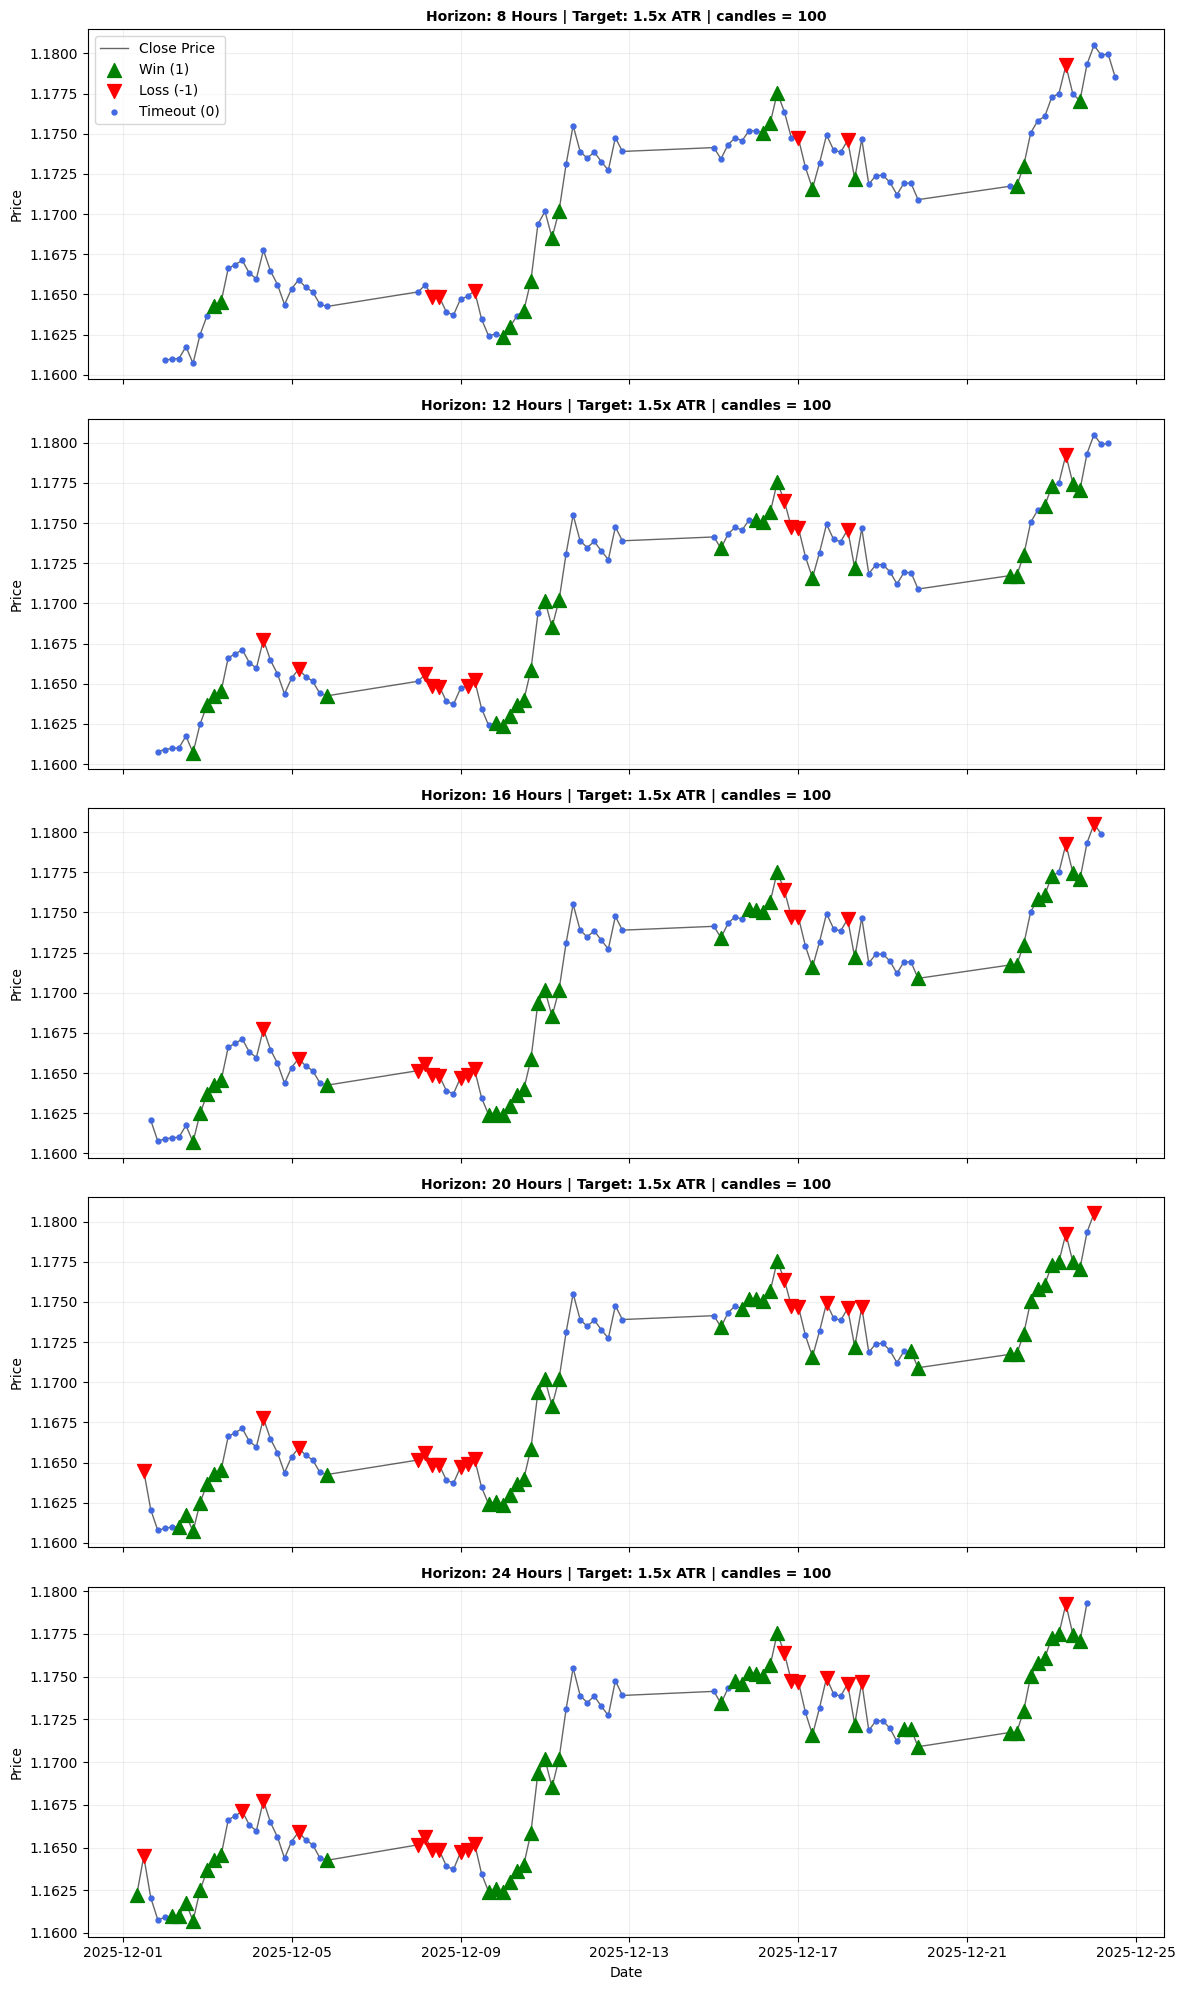

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# 1. Setup
data_folder = '../data'
hour_horizons = [8, 12, 16, 20, 24]
plot_slice = 100 # Number of candles to zoom in on
pt_multiplier = 1.5 # Used for title labeling only

# Create subplots
fig, axes = plt.subplots(len(hour_horizons), 1, figsize=(12, 20), sharex=True)

print(f"Reading files from {data_folder} and plotting last {plot_slice} candles...\n")

for idx, hours in enumerate(hour_horizons):
    # 2. Load the specific file for this horizon
    filename = f"triple_barrier_{hours}h.csv"
    filepath = os.path.join(data_folder, filename)
    
    # Read CSV (Parse index as dates!)
    df_full = pd.read_csv(filepath, index_col=0, parse_dates=True)
    
    # Slice the data for zooming
    df_plot = df_full.iloc[-plot_slice:].copy()
    
    ax = axes[idx]
    
    # 3. Plot Price
    ax.plot(df_plot.index, df_plot['close'], color='black', alpha=0.6, linewidth=1, label='Close Price')
    
    # 4. Filter Outcomes
    wins = df_plot[df_plot['label'] == 1]
    losses = df_plot[df_plot['label'] == -1]
    timeouts = df_plot[df_plot['label'] == 0]
    
    # 5. Plot Markers
    # Green Up Triangle = Win
    ax.scatter(wins.index, wins['close'], color='green', marker='^', s=100, label='Win (1)', zorder=3)
    
    # Red Down Triangle = Loss
    ax.scatter(losses.index, losses['close'], color='red', marker='v', s=100, label='Loss (-1)', zorder=3)
    
    # Blue Dot = Timeout (Sideways/No Trade)
    ax.scatter(timeouts.index, timeouts['close'], color='royalblue', marker='.', s=50, label='Timeout (0)', zorder=2)
    
    # 6. Styling
    ax.set_title(f"Horizon: {hours} Hours | Target: {pt_multiplier}x ATR | candles = {plot_slice}", fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.2)
    ax.set_ylabel("Price")
    
    # Legend only on the first plot to avoid clutter
    if idx == 0:
        ax.legend(loc='upper left', frameon=True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Cell 2: Class Balance Statistics

In [72]:
import pandas as pd
import os

data_folder = '../data'
hour_horizons = [8, 12, 16, 20, 24]

summary_stats = []

for hours in hour_horizons:
    # 1. Load File
    filename = f"triple_barrier_{hours}h.csv"
    filepath = os.path.join(data_folder, filename)
    df = pd.read_csv(filepath)
    
    # 2. Count Classes
    # normalize=True gives fractions (0.5), multiplying by 100 gives percentages (50.0)
    counts = df['label'].value_counts(normalize=True) * 100
    
    # 3. Store in a dictionary safely (using .get in case a class doesn't exist yet)
    stats = {
        'Horizon': f"{hours} Hours",
        'Win (1) %': round(counts.get(1.0, 0), 2),
        'Loss (-1) %': round(counts.get(-1.0, 0), 2),
        'Timeout (0) %': round(counts.get(0.0, 0), 2),
        'Total Samples': len(df)
    }
    summary_stats.append(stats)

# 4. Display as a clean DataFrame
stats_df = pd.DataFrame(summary_stats)

# styling for better readability
print("--- Class Balance Distribution ---")
stats_df

--- Class Balance Distribution ---


,Horizon,Win (1) %,Loss (-1) %,Timeout (0) %,Total Samples
0,8 Hours,12.01,12.31,75.69,9303
1,12 Hours,18.60,18.80,62.60,9302
2,16 Hours,24.45,24.59,50.96,9301
3,20 Hours,29.71,29.94,40.35,9300
4,24 Hours,33.62,33.86,32.52,9299


### Save

In [ ]:
# Cell 4: Save
df.to_parquet(LABELED_FILE)
print("💾 Saved Labeled Data.")